In [65]:
import numpy as np
import scipy.interpolate as si
import copy
import matplotlib.pylab as plt
import matplotlib.patches as patches

In [66]:
%matplotlib inline

In [67]:
def read_airfoil_coordinates(filename):
    with open(filename, 'r') as f:
        data = f.readlines()
        data = [line for line in data if not '#' in line]
        x = [float(l.split()[0]) for l in data]
        y = [float(l.split()[1]) for l in data]
        return x, y

In [68]:
class ContourAnalysis(object):
    """Summary

    Attributes:
        canvas (TYPE): Description
        curvature_data (TYPE): Description
        figure (TYPE): Description
        parent (QMainWindow object): MainWindow instance
        raw_coordinates (list): contour points as tuples
        spline_data (TYPE): Description
        toolbar (TYPE): Description
    """
    def __init__(self):

        self.spline_data = None
        self.curvature_data = None

    def spline(self, x, y, points=200, degree=2, evaluate=False):
        """Interpolate spline through given points

        Args:
            spline (int, optional): Number of points on the spline
            degree (int, optional): Degree of the spline
            evaluate (bool, optional): If True, evaluate spline just at
                                       the coordinates of the knots
        """

        # interpolate B-spline through data points
        # returns knots of control polygon
        # tck ... tuple (t,c,k) containing the vector of knots,
        # the B-spline coefficients, and the degree of the spline.
        # u ... array of the parameters for each knot
        tck, u = si.splprep([x, y], s=0, k=degree)

        # number of points on interpolated B-spline (parameter t)
        t = np.linspace(0.0, 1.0, points)

        # if True, evaluate spline just at the coordinates of the knots
        if evaluate:
            t = u

        # evaluate B-spline at given parameters
        # der=0: returns point coordinates
        coo = si.splev(t, tck, der=0)

        # evaluate 1st derivative at given parameters
        der1 = si.splev(t, tck, der=1)

        # evaluate 2nd derivative at given parameters
        der2 = si.splev(t, tck, der=2)

        self.spline_data = [coo, u, t, der1, der2, tck]

        return self.spline_data

    def refine(self, tol=170.0, recursions=0, verbose=False):
        """Recursive refinement with respect to angle criterion (tol).
        If angle between two adjacent line segments is less than tol,
        a recursive refinement of the contour is performed until
        tol is met.

        Args:
            tol (float, optional): Angle between two adjacent contour segments
            recursions (int, optional): NO USER INPUT HERE
                                        Needed just for level information
                                        during recursions
            verbose (bool, optional): Activate logger messages
        """

        # self.spline_data = [coo, u, t, der1, der2, tck]
        xx, yy = self.spline_data[0]
        t = self.spline_data[2]
        tck = self.spline_data[5]

        if verbose:
            logger.log.info('\nPoints before refining: %s \n' % (len(xx)))

        xn = copy.deepcopy(xx)
        yn = copy.deepcopy(yy)
        tn = copy.deepcopy(t)

        j = 0
        refinements = 0
        first = True
        refined = dict()

        for i in range(len(xx) - 2):
            refined[i] = False

            # angle between two contour line segments
            a = np.array([xx[i], yy[i]])
            b = np.array([xx[i + 1], yy[i + 1]])
            c = np.array([xx[i + 2], yy[i + 2]])
            angle = angle_between(a - b, c - b, degree=True)

            if angle < tol:

                refined[i] = True
                refinements += 1

                # parameters for new points
                t1 = (t[i] + t[i + 1]) / 2.
                t2 = (t[i + 1] + t[i + 2]) / 2.

                # coordinates of new points
                p1 = si.splev(t1, tck, der=0)
                p2 = si.splev(t2, tck, der=0)

                # insert points and their parameters into arrays
                if i > 0 and not refined[i - 1]:
                    xn = np.insert(xn, i + 1 + j, p1[0])
                    yn = np.insert(yn, i + 1 + j, p1[1])
                    tn = np.insert(tn, i + 1 + j, t1)
                    j += 1
                xn = np.insert(xn, i + 2 + j, p2[0])
                yn = np.insert(yn, i + 2 + j, p2[1])
                tn = np.insert(tn, i + 2 + j, t2)
                j += 1

                if first and recursions > 0:
                    if verbose:
                        logger.log.info('Recursion level: %s \n' %
                                        (recursions))
                    first = False

                if verbose:
                    logger.log.info('Refining between %s %s, Tol=%05.1f Angle=%05.1f\n'
                                    % (i, i + 1, tol, angle))

        if verbose:
            logger.log.info('Points after refining: %s' % (len(xn)))

        # update coordinate array, including inserted points
        self.spline_data[0] = (xn, yn)
        # update parameter array, including parameters of inserted points
        self.spline_data[2] = tn

        # recursive refinement
        if refinements > 0:

            self.refine(tol, recursions + 1, verbose)

        # stopping from recursion if no refinements done in this recursion
        else:

            # update derivatives, including inserted points
            self.spline_data[3] = si.splev(tn, tck, der=1)
            self.spline_data[4] = si.splev(tn, tck, der=2)

            if verbose:
                logger.log.info('No more refinements.')
                logger.log.info('\nTotal number of recursions: %s'
                                % (recursions - 1))
            return

    def getCurvature(self):
        """Curvature and radius of curvature of a parametric curve

        der1 is dx/dt and dy/dt at each point
        der2 is d2x/dt2 and d2y/dt2 at each point

        Returns:
            float: Tuple of numpy arrays carrying gradient of the curve,
                   the curvature, radiusses of curvature circles and
                   curvature circle centers for each point of the curve
        """

        coo = self.spline_data[0]
        der1 = self.spline_data[3]
        der2 = self.spline_data[4]

        xd = der1[0]
        yd = der1[1]
        x2d = der2[0]
        y2d = der2[1]
        n = xd**2 + yd**2
        d = xd*y2d - yd*x2d

        # gradient dy/dx = dy/du / dx/du
        gradient = der1[1] / der1[0]
        # radius of curvature
        R = n**(3./2.) / abs(d)
        # curvature
        C = d / n**(3./2.)

        # coordinates of curvature-circle center points
        xc = coo[0] - R * yd / np.sqrt(n)
        yc = coo[1] + R * xd / np.sqrt(n)

        self.curvature_data = [gradient, C, R, xc, yc]
        return self.curvature_data

    def analyze(self, tolerance, spline_points):

        # raw coordinates are stored as numpy array
        # np.array( (x, y) )

        # interpolate a spline through the raw contour points
        x, y = self.raw_coordinates
        self.spline(x, y, points=spline_points, degree=2)

        # refine the contour in order to meet the tolerance
        self.refine(tol=tolerance, verbose=False)
        
        # redo spline on refined contour
        # evaluate=True --> spline only evaluated at refined contour points
        coo, u, t, der1, der2, tck = self.spline_data
        x, y, = coo
        self.spline(x, y, points=spline_points, degree=2, evaluate=True)

        # get specific curve properties
        curve_data = self.getCurvature()
        
        return  curve_data, self.spline_data

In [69]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(a, b, degree=False):
    """Returns the angle between
    vectors 'a' and 'b'
    """
    a_u = unit_vector(a)
    b_u = unit_vector(b)
    angle = np.arccos(np.clip(np.dot(a_u, b_u), -1.0, 1.0))
    if degree:
        angle *= 180.0 / np.pi
    return angle

In [70]:
x, y = read_airfoil_coordinates('NACA0012.txt')

In [71]:
analysis = ContourAnalysis()

In [72]:
analysis.raw_coordinates = (x, y)

In [73]:
tol = 173.0
points = 50
curvature, spline_data = analysis.analyze(tol, points)

In [74]:
gradient, C, R, xc, yc = curvature
coo, u, t, der1, der2, tck = spline_data

In [75]:
xs, ys = coo

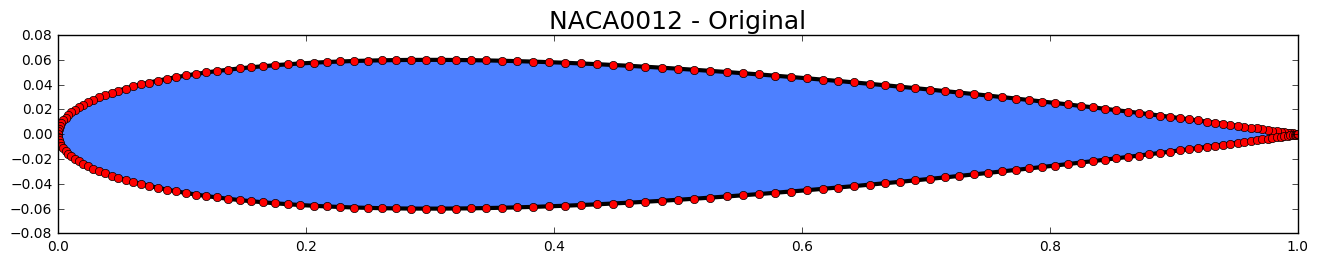

In [76]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)

ax.plot(x,y, 'k', linewidth=3)
ax.plot(x,y, 'ro', linewidth=3)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(-0.08, 0.08)
ax.set_title('NACA0012 - Original', fontsize=18)
ax.fill(x, y, color=(0.3, 0.5, 1))
ax.set_aspect('equal')

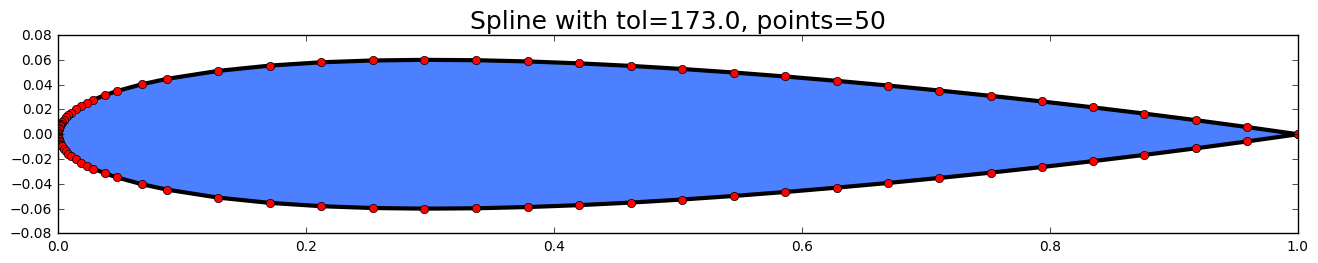

In [77]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)

ax.plot(xs, ys, 'k', linewidth=3)
ax.plot(xs, ys, 'ro', linewidth=3)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(-0.08, 0.08)
ax.set_title('Spline with tol=%s, points=%s' % (tol, points), fontsize=18)
ax.fill(xs, ys, color=(0.3, 0.5, 1))
ax.set_aspect('equal')

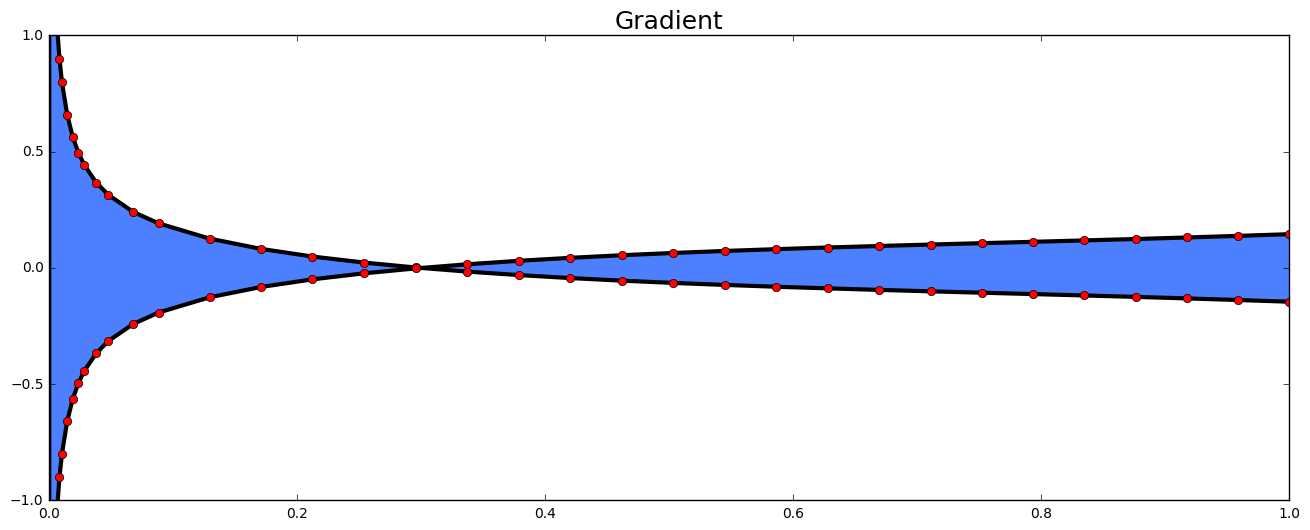

In [78]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(xs, gradient, 'k', linewidth=3)
ax.plot(xs, gradient, 'ro', linewidth=3)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(-1, 1)
ax.set_title('Gradient', fontsize=18)
ax.fill(xs, gradient, color=(0.3, 0.5, 1))

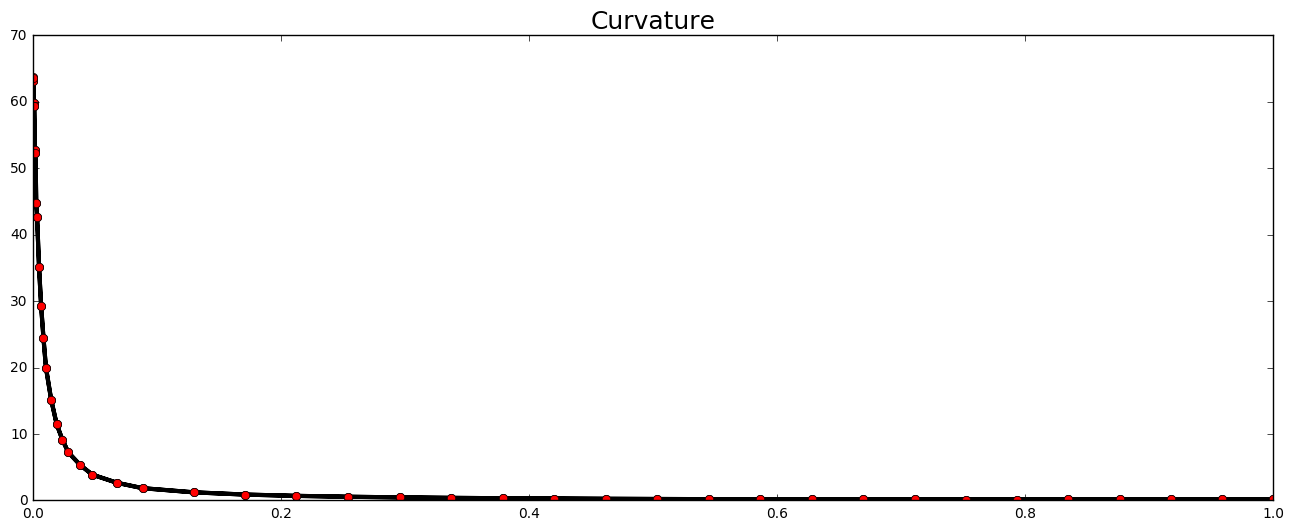

In [79]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(xs, C, 'k', linewidth=3)
ax.plot(xs, C, 'ro', linewidth=3)
ax.set_xlim(0.0, 1.0)
#ax.set_ylim(-1, 1)
ax.set_title('Curvature', fontsize=18)
ax.fill(xs, C, color=(0.3, 0.5, 1))

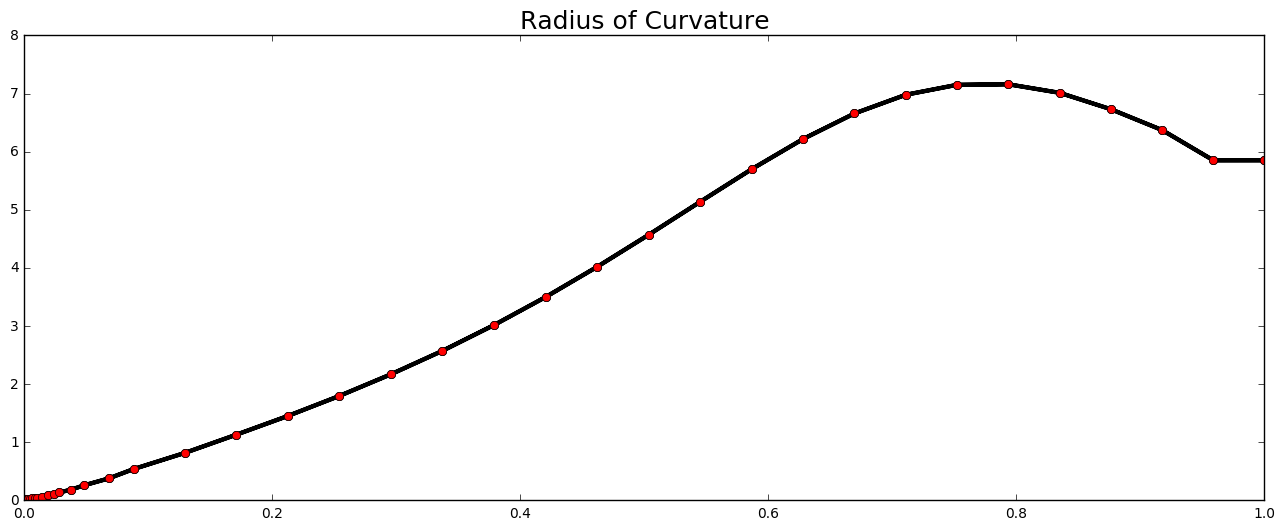

In [80]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(1, 1, 1)

ax.plot(xs, R, 'k', linewidth=3)
ax.plot(xs, R, 'ro', linewidth=3)
ax.set_xlim(0.0, 1.0)
#ax.set_ylim(-1, 1)
ax.set_title('Radius of Curvature', fontsize=18)
ax.fill(xs, R, color=(0.3, 0.5, 1))

In [81]:
# identify leading edge radius (i.e. smallest radius of parametric curve)
r = np.min(R)
le_id = np.where(R == r)
# leading edge curvature circle center
xr = xc[le_id]
yr = yc[le_id]

In [82]:
xr, yr, r

(array([ 0.01569701]), array([ -8.98433210e-18]), 0.015697006318121397)

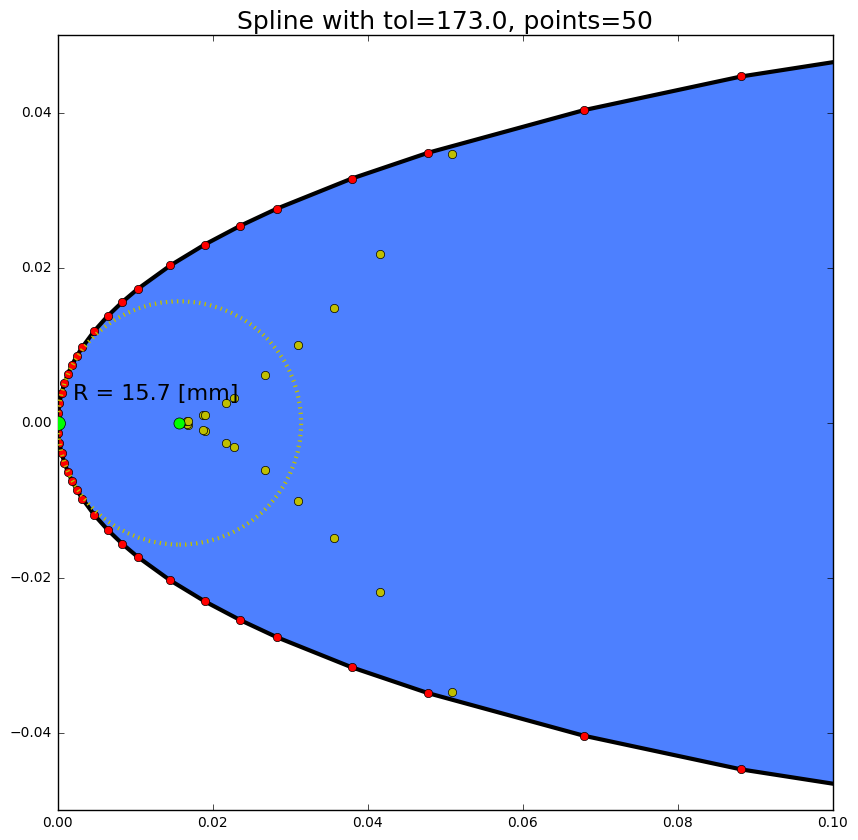

In [92]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1)
circle = patches.Circle( (xr, yr) , r, edgecolor='y', facecolor='None', linewidth=3, zorder=10, ls='dotted')

ax.plot(xs, ys, 'k', linewidth=3)
ax.plot(xs, ys, 'ro', linewidth=3)
ax.set_xlim(0.0, 0.1)
ax.set_ylim(-0.05, 0.05)
ax.set_title('Spline with tol=%s, points=%s' % (tol, points), fontsize=18)
ax.fill(xs, ys, color=(0.3, 0.5, 1))
ax.set_aspect('equal')
# curvature circle center points
ax.plot(xc, yc, 'yo', zorder=40)
# leading edge point
ax.plot(coo[0][le_id], coo[1][le_id], marker='o', zorder=50, color='lime', markersize=10)
# leading edge curvature circle center
ax.plot(xr, yr, marker='o', zorder=50, color='lime', markersize=8)
# leading edge curvature circle
ax.add_patch(circle)
ax.text(0.002, 0.003, 'R = '+ str(np.round(r, 5)*1000)+' [mm]', fontsize=16, zorder=60)